In [19]:
import os
import sys
sys.path.append(os.path.abspath("../"))

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
import urllib.request

def download_file(url, filepath):
    urllib.request.urlretrieve(url, filepath)

まずは、サンプルデータを取得する。

In [21]:
url = "https://raw.githubusercontent.com/iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv"
filepath = "../data/sample.csv"

if not os.path.exists(filepath):
    download_file(url, filepath)

df = pd.read_csv(filepath)

In [22]:
print(f'データサイズ: {df.shape[0]:,}')
df.head()

データサイズ: 10,000


,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,...,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,...,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,...,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,...,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,1,0,0,49.344942,0,0


ここでは、「テレビCMの接触有無」が「スマートフォンアプリの利用時間」にどれくらい影響するのかを分析する。

最も簡単にCMがアプリ利用時間に影響する効果を計算する方法は、「CMを見た人の平均スマートフォンアプリの利用時間」と「CMを見みてない人の平均スマートフォンアプリの利用時間 」の差になる。

In [23]:
treat = df.loc[df.cm_dummy==1, 'gamesecond']
control = df.loc[df.cm_dummy==0, 'gamesecond']

print(f'CM接触者の平均アプリ利用時間: {treat.mean():.2f}　（標準偏差：{treat.std():.2f}）')
print(f'CM非接触者の平均アプリ利用時間: {control.mean():.2f}　（標準偏差：{control.std():.2f}）')
print(f'CM接触による平均効果: {treat.mean() - control.mean():.02f}')

CM接触者の平均アプリ利用時間: 2478.07　（標準偏差：15564.02）
CM非接触者の平均アプリ利用時間: 3107.71　（標準偏差：19496.77）
CM接触による平均効果: -629.64


最も簡単な比較方法では、CMに接触したほうがアプリの利用時間が短くなるという結果になった。

しかし、これは明らかに不自然な結果に思える。

そこで、次にセレクションバイアスの可能性について考えてみる。

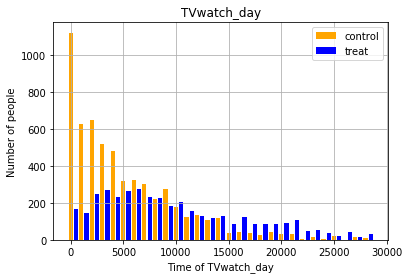

In [24]:
plt.title('TVwatch_day')
plt.ylabel('Number of people')
plt.xlabel('Time of TVwatch_day')
df.loc[df['cm_dummy']==0, 'TVwatch_day'].hist(
    bins=np.arange(0, 30000, 1000), align='left', rwidth=0.4, color='orange', label='control')
df.loc[df['cm_dummy']==1, 'TVwatch_day'].hist(
    bins=np.arange(0, 30000, 1000), align='mid', rwidth=0.4, color='blue', label='treat')
plt.legend()
plt.show()

上記の図から、CM非接触者（control）は、平均的にテレビの視聴時間が短い人が多いことがわかる。

逆に、CM接触者（treat）は、平均的にテレビの視聴時間が長い。

よって、アプリをよく利用するユーザーは平均的にテレビを見る時間が短く、CMに接触する確率が低い可能性が考えられる。

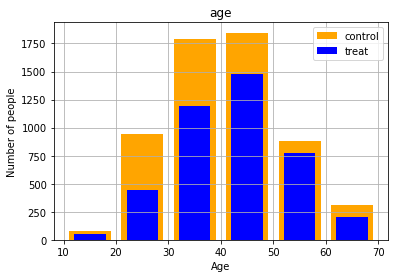

In [25]:
plt.title('age')
plt.ylabel('Number of people')
plt.xlabel('Age')
df.loc[df['cm_dummy']==0, 'age'].hist(
    bins=np.arange(10, 80, 10), rwidth=0.8, color='orange', label='control')
df.loc[df['cm_dummy']==1, 'age'].hist(
    bins=np.arange(10, 80, 10), rwidth=0.6, color='blue', label='treat')
plt.legend()
plt.show()

性別による偏りはみられない。

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

target_col = 'cm_dummy'

X = df.drop(target_col, axis=1)
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


clf = LogisticRegression(random_state=0, solver='lbfgs', n_jobs=-1)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [27]:
inferenced_df = pd.concat([X_test, y_test], axis=1)
inferenced_df['propensity_score'] = clf.predict_proba(X_test)[:, 1]
inferenced_df.head()

,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,job_dummy2,...,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount,cm_dummy,propensity_score
6252,0,0,1,0,0,54.5,1,1,1,0,...,0,0,0,0,1,14277.681213,0,0,1,0.501461
4684,0,0,1,0,0,44.5,1,1,0,1,...,0,0,0,1,0,13119.213915,0,0,0,0.512759
1731,0,0,1,0,0,44.5,1,1,1,0,...,0,0,0,1,0,4943.086155,0,0,0,0.307938
4742,0,0,0,0,1,24.5,0,1,0,0,...,0,0,0,0,0,23087.531735,0,0,0,0.882568
4521,0,0,1,0,0,44.5,0,1,0,0,...,1,0,0,0,0,6596.596965,0,0,0,0.418577


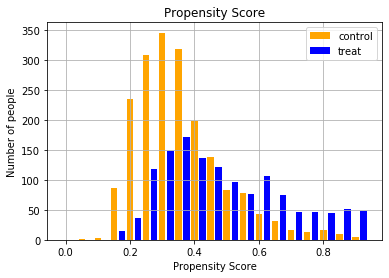

In [28]:
plt.title('Propensity Score')
plt.ylabel('Number of people')
plt.xlabel('Propensity Score')
inferenced_df.loc[inferenced_df['cm_dummy']==0, 'propensity_score'].hist(
    bins=np.arange(0, 1, 0.05), align='left', rwidth=0.4, color='orange', label='control')
inferenced_df.loc[inferenced_df['cm_dummy']==1, 'propensity_score'].hist(
    bins=np.arange(0, 1, 0.05), align='mid', rwidth=0.4, color='blue', label='treat')
plt.legend()
plt.show()

上記で求められた傾向スコアを元にマッチング処理を行う。

傾向スコアが近いサンプルを treat/control 間で１対１でサンプリングすることで、各集団の偏り（セレクションバイアス）をなくす。

In [29]:
%load_ext autoreload
%autoreload

from libs import PropensityScoreMatching

model = PropensityScoreMatching()
model.test()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
pass test
